# Real or Not? NLP with Disaster Tweets



## Competition 

In this competition, we want to predict which Tweets are about real disasters and which ones are not. Then for each tweet (input), we want to know if it refers to a disaster event (output). The output of our system will be a boolean (true or false).

1) Explore data.
2) Preprocess data
3) TF-IDF implementation.
4) SVM.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Explore our data

In [5]:
# Read the data 
import pandas as pd
train_data = pd.read_csv('F:/nlp fastai/DisasterTweetsNLP1master/data/train.csv')
test_data  = pd.read_csv('F:/nlp fastai/DisasterTweetsNLP1master/data/test.csv')

# Show some training data
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


As you can see, in our training data, we have 3 features :
- Keyword : a particular keyword from the tweet (may be blank)
- Location : the location the tweet was sent from (may be blank)
- Text : the text of the tweet


In [7]:
print("Training :")
print("Length of the data :", len(train_data))
# Missing value in the training set
print(train_data.isnull().sum())

Training :
Length of the data : 7613
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
print("Test :")
print("Length of the data :", len(test_data))
# Missing value in the test set
print(test_data.isnull().sum())

Test :
Length of the data : 3263
id             0
keyword       26
location    1105
text           0
dtype: int64


Text(0, 0.5, 'samples')

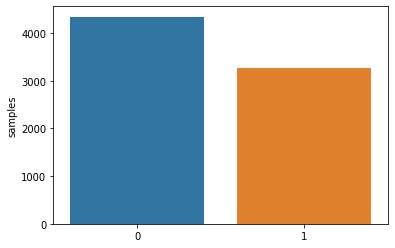

In [9]:
# Distributy if the target 
target_values = train_data['target'].value_counts()
sns.barplot(target_values.index, target_values)
plt.gca().set_ylabel('samples')

# Text preprocessing - Normalization

In this part, we are going to normalize our data. Firt of all, we are going to **tokenize** our data. We are going to split our phrase into array of word. We need to separate the word and also the ponctuation.

In [10]:
from nltk.tokenize import word_tokenize

# Extract all the words
tokens = word_tokenize(train_data["text"][0])

# Lowercase the words
tokens = [word.lower() for word in tokens]

print(train_data["text"][0])
print(tokens)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']


Then, we are going to remove all the ponctuation.

In [11]:
# Remove all tokens that are not alphabetic
words = [word for word in tokens if word.isalpha()]
print(words)

['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']


In order to describe our tweet with word, we need to remove the "stopwords". That means all the basic word like 'the', 'you'... These words are present in all documents, so they can't be use to differentiate tweet. 

In [12]:
# Filters - Remove stop words
from nltk.corpus import stopwords

# Get all stop words
stop_words = set(stopwords.words("english"))

words = [word for word in words if not word in stop_words]
print(words)

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']


In [13]:
# Stem Words (Racinisation)
# Process of reducins inflected words to their word stem, base or root form.
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
stemmed = [porter.stem(word) for word in words]

print(stemmed)

['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']


In [14]:
import re
import string

#Function for removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

#Function for removing HTML codes
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

#Function for removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


#Function for removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train_data['text']=train_data['text'].apply(remove_URL)
train_data['text']=train_data['text'].apply(remove_html)
train_data['text']=train_data['text'].apply(remove_emoji)
train_data['text']=train_data['text'].apply(remove_punct)


test_data['text'] = test_data['text'].apply(remove_URL)
test_data['text'] = test_data['text'].apply(remove_html)
test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_punct)


In [15]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Get all stop words
stop_words = set(stopwords.words("english"))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    
    # Extract all the words
    tokens = word_tokenize(text)
    
    # Lowercase the words
    tokens = [word.lower() for word in tokens]
    
    # Remove all tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha()]
    
    # Remove word in the stop word
    words = [word for word in words if not word in stop_words]

    # Get the root of the word 
    stemmed = [porter.stem(word) for word in words]
    
    # Lematize the word
    lematized = [lemmatizer.lemmatize(word) for word in stemmed]

    return lematized

train_data["preprocess_text"] = train_data.text.apply(preprocess_text)
test_data["preprocess_text"] = test_data.text.apply(preprocess_text)
train_data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,keyword,location,text,target,preprocess_text
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deed, reason, earthquak, may, allah, forgiv, u]"
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,"[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,"[resid, ask, shelter, place, notifi, offic, ev..."
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[peopl, receiv, wildfir, evacu, order, califor..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [16]:
def join_list(tab):
    return " ".join(tab)
train_data["text_preprocessed"] = train_data["preprocess_text"].apply(join_list)
test_data["text_preprocessed"] = test_data["preprocess_text"].apply(join_list)

def transform_keyword(word) :
    # Split when %20
    return word.split('%20')

# Transform NaN value to empty string
train_data["keyword"] = train_data.keyword.fillna(" ")
test_data["keyword"] = test_data.keyword.fillna(" ")

train_data["keyword"] = train_data["keyword"].apply(transform_keyword).apply(join_list)
test_data["keyword"] = test_data["keyword"].apply(transform_keyword).apply(join_list)

# Concant keyword to the phrases
train_data["text_preprocessed"] = train_data["keyword"] + " " + train_data["text_preprocessed"] 
test_data["text_preprocessed"] = test_data["keyword"] + " " + test_data["text_preprocessed"] 

# TF-IDF 

In [17]:
from sklearn.model_selection import train_test_split

X_all = pd.concat([train_data["text_preprocessed"], test_data["text_preprocessed"]])

tfidf = TfidfVectorizer(stop_words = 'english')
tfidf.fit(X_all)

X = tfidf.transform(train_data["text_preprocessed"])
X_test = tfidf.transform(test_data["text_preprocessed"])
del X_all

train, test = train_test_split(train_data, test_size=0.2)

train_x = train["text_preprocessed"]
train_y = train["target"]

test_x = test["text_preprocessed"]
test_y = test["target"]


X_train, X_val, y_train, y_val = train_test_split(X, train_data["target"], test_size=0.1, random_state=42)


# SVM

In [18]:
parameters = { 
    'gamma': [0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.7, 1], 
    'kernel': ['rbf'], 
    'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 3, 10],
}

# {'C': 2, 'gamma': 0.9, 'kernel': 'rbf'}

In [19]:
# parameters = { 
#     'gamma':  [0.5],
#     'kernel': ['rbf'], 
#     'C':[2]
# }
model = GridSearchCV(SVC(), parameters, cv=10, n_jobs=-1).fit(X_train, y_train)

In [20]:
model.cv_results_['params'][model.best_index_]

{'C': 1.5, 'gamma': 0.6, 'kernel': 'rbf'}

In [21]:
y_val_pred = model.predict(X_val)
accuracy_score(y_val, y_val_pred), f1_score(y_val, y_val_pred)

(0.7821522309711286, 0.7242524916943522)

In [22]:
confusion_matrix(y_val, y_val_pred)

array([[378,  48],
       [118, 218]], dtype=int64)

In [23]:
y_test_pred = model.predict(X_test)

In [25]:
sub_df = pd.read_csv( 'F:/nlp fastai/DisasterTweetsNLP1master/data/sample_submission.csv')
sub_df["target"] = y_test_pred
sub_df.to_csv("F:/nlp fastai/DisasterTweetsNLP1master/submission3.csv",index=False)